# Load Data

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape,LSTM, GRU, SimpleRNN, TimeDistributed
from keras.utils import to_categorical
from keras.models import Model
from keras import layers, regularizers
import matplotlib.pyplot as plt
import os


In [2]:
data_folder = './EEG-Data'
os.chdir(data_folder)
print(os.getcwd())

c:\Users\tiffh\ECE-C147\Deep-Learning-EEG-BCI-Signal-Processing\EEG-Data


(2115, 22, 1000)


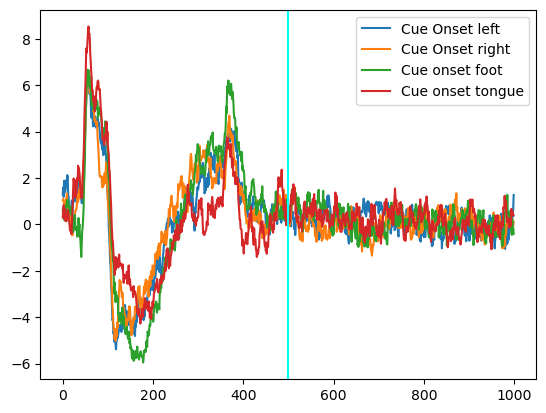

In [3]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])






In [4]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X

## Preprocessing the dataset

# X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep = test_data_prep(X_test) 

## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 250, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
x_valid_prep = test_data_prep(x_valid)
x_train, y_train = train_data_prep(x_train, y_train, 2,2,True)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid_prep.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid_prep.reshape(x_valid_prep.shape[0], x_valid_prep.shape[1], x_valid_prep.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (250, 22, 800)
Shape of X after maxpooling: (250, 22, 400)
Shape of X after trimming: (1865, 22, 800)
Shape of X after maxpooling: (1865, 22, 400)
Shape of X after averaging+noise and concatenating: (3730, 22, 400)
Shape of X after subsampling and concatenating: (7460, 22, 400)
Shape of Y: (7460,)
Shape of training set: (7460, 22, 400)
Shape of validation set: (250, 22, 400)
Shape of training labels: (7460,)
Shape of validation labels: (250,)
Shape of training labels after categorical conversion: (7460, 4)
Shape of validation labels after categorical conversion: (250, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7460, 22, 400, 1)
Shape of validation set after adding width info: (250, 22, 400, 1)
Shape of test set after adding width info: (443, 22, 400, 1)
Shape of training set after dimension reshaping: (7460,

# Hybrid Model Architecture

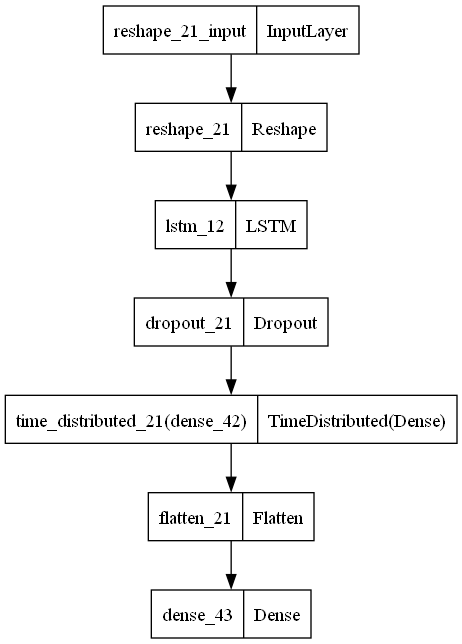

In [47]:
def create_lstm_model(units=32, dropout=0.4, dense=16):
    # Building the model using sequential class
    lstm_model = Sequential()

    # # FC layer
    lstm_model.add(Reshape((400, 22)))
    lstm_model.add(LSTM(units, input_shape=(400,22), return_sequences=True)) #dropout=0.4, recurrent_dropout=0.1,
    lstm_model.add(Dropout(dropout))
    # lstm_model.add(LSTM(10, activation='sigmoid', dropout=0.4, recurrent_dropout=0.1, return_sequences=True))
    # lstm_model.add(Dropout(0.2))
    lstm_model.add(TimeDistributed(Dense((dense))))
    # Output layer with Softmax activation 
    lstm_model.add(Flatten())
    lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

    lstm_model.build((1, 400, 1, 22))
    # Printing the model summary
    # lstm_model.summary()
    return lstm_model

best_lstm = create_lstm_model(64, 0.1, 8)
keras.utils.plot_model(best_lstm, to_file="../Gallery/LSTM_architecture_plot.png", show_shapes=False)



In [45]:

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz-10.0.1-win64/bin/'


# Train Hybrid Model

In [13]:
# Model parameters
learning_rate = 1e-4
epochs = 5
hybrid_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [14]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import pickle
# ModelCheckpoint?
# checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, 
#                     monitor="val_loss", mode="min", 
#                     save_best_only=True, verbose=1)
# model.load_weights(model_file)

dropouts = [0.1]
units = [64]
dense = [8, 16, 32]
batch_sizes = [8, 16, 32]

results = {}

for dr in dropouts:
    for u in units:
        for d in dense:
            for b in batch_sizes:
                lstm_model = create_lstm_model(u, dr, d)
                # Compiling the model
                lstm_model.compile(loss='categorical_crossentropy',
                                optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                                metrics=['accuracy'])

                reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                                            patience=5, min_lr=5e-5)
                # early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

                # Training and validating the model
                lstm_model_results = lstm_model.fit(x_train,
                            y_train,
                            batch_size=b,
                            epochs=epochs,
                            validation_data=(x_valid, y_valid), 
                            callbacks=[reduce_lr],
                            verbose=True)
                
                results["units:"+str(u)+" dropout:"+str(dr)+ " dense:"+str(d)+" batch_size:"+str(b)] = lstm_model_results
        
                score = lstm_model.evaluate(x_test, y_test, verbose=0)
                model_filename = f'../Models/0_LSTM_{score[1]}_{u}_{dr}_{d}_{b}.h5'
                lstm_model.save(model_filename)






Epoch 1/5
933/933 [==============================] - 116s 123ms/step - loss: 1.2612 - accuracy: 0.4184 - val_loss: 1.2348 - val_accuracy: 0.4640 - lr: 1.0000e-04
Epoch 2/5
933/933 [==============================] - 115s 124ms/step - loss: 0.8748 - accuracy: 0.6562 - val_loss: 1.1966 - val_accuracy: 0.5040 - lr: 1.0000e-04
Epoch 3/5
933/933 [==============================] - 150s 161ms/step - loss: 0.6644 - accuracy: 0.7519 - val_loss: 1.2199 - val_accuracy: 0.5160 - lr: 1.0000e-04
Epoch 4/5
933/933 [==============================] - 93s 100ms/step - loss: 0.5178 - accuracy: 0.8225 - val_loss: 1.3047 - val_accuracy: 0.5320 - lr: 1.0000e-04
Epoch 5/5
933/933 [==============================] - 93s 100ms/step - loss: 0.4026 - accuracy: 0.8721 - val_loss: 1.3456 - val_accuracy: 0.5320 - lr: 1.0000e-04


c:\Users\tiffh\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/5
467/467 [==============================] - 45s 92ms/step - loss: 1.3646 - accuracy: 0.3536 - val_loss: 1.3180 - val_accuracy: 0.3840 - lr: 1.0000e-04
Epoch 2/5
467/467 [==============================] - 47s 101ms/step - loss: 1.1115 - accuracy: 0.5217 - val_loss: 1.2520 - val_accuracy: 0.4720 - lr: 1.0000e-04
Epoch 3/5
467/467 [==============================] - 57s 122ms/step - loss: 0.9052 - accuracy: 0.6479 - val_loss: 1.1822 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/5
467/467 [==============================] - 77s 165ms/step - loss: 0.7466 - accuracy: 0.7235 - val_loss: 1.1525 - val_accuracy: 0.5480 - lr: 1.0000e-04
Epoch 5/5
467/467 [==============================] - 76s 163ms/step - loss: 0.6166 - accuracy: 0.7847 - val_loss: 1.1384 - val_accuracy: 0.5600 - lr: 1.0000e-04
Epoch 1/5
234/234 [==============================] - 54s 219ms/step - loss: 1.4278 - accuracy: 0.3005 - val_loss: 1.4051 - val_accuracy: 0.3000 - lr: 1.0000e-04
Epoch 2/5
234/234 [================

In [15]:
with open('./lstm_results_dict_actual', 'wb') as fp:
    pickle.dump(results, fp)

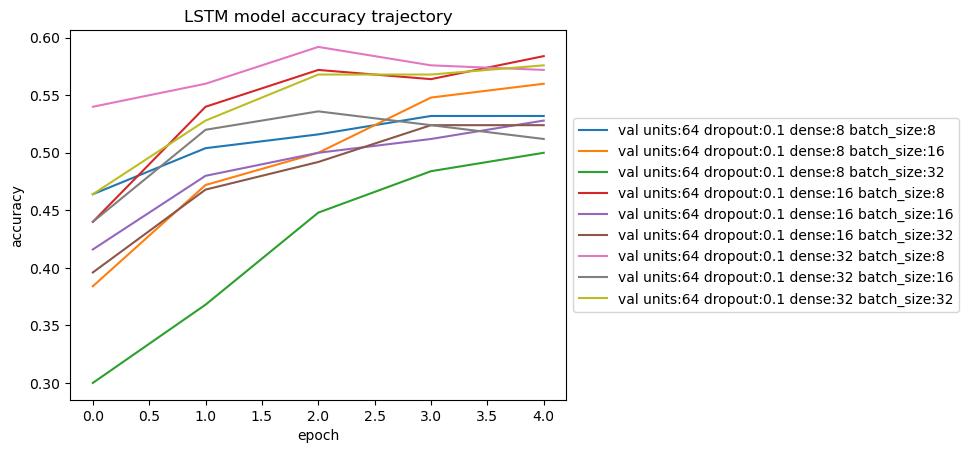

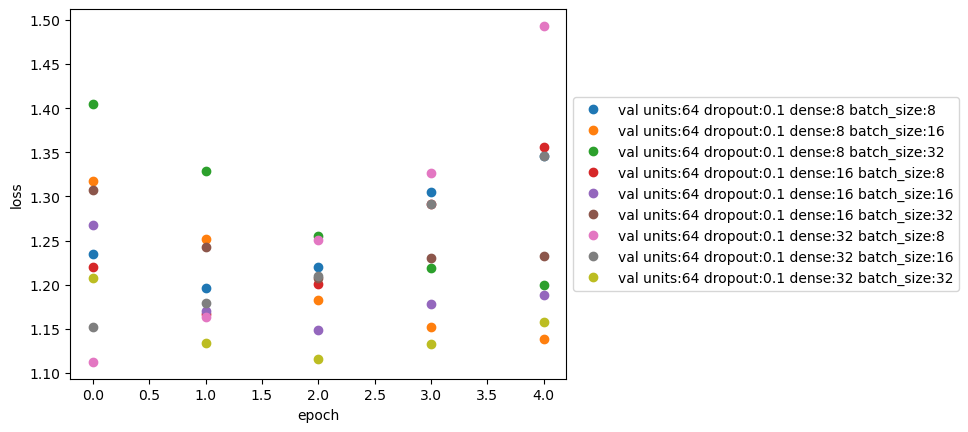

In [19]:
import matplotlib.pyplot as plt

for key in results.keys():
    # plt.plot(results[key].history['accuracy'], label="train "+key)
    plt.plot(results[key].history['val_accuracy'], label="val "+key)
plt.title('LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plotting loss trajectory
for key in results.keys():
    # plt.plot(results[key].history['loss'],'o', label="train "+key)
    plt.plot(results[key].history['val_loss'],'o', label="val "+key)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Retrain most promising model

In [35]:
model = keras.models.load_model('../Models/0_LSTM_0.5282167196273804_64_0.1_8_16.h5')

In [36]:
epochs = 3
# learning_rate = 1e-5
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# model.compile(loss='categorical_crossentropy',
#                                 optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
#                                 metrics=['accuracy'])

# Training and validating the model
lstm_model_results2 = model.fit(x_train,
            y_train,
            batch_size=16,
            epochs=8,
            initial_epoch=5, 
            validation_data=(x_valid, y_valid), 
            verbose=True)

# results["units:"+str(u)+" dropout:"+str(dr)+ " dense:"+str(d)+" batch_size:"+str(b)] = lstm_model_results

score = model.evaluate(x_test, y_test, verbose=0)
model_filename = f'../Models/0_LSTM_{score[1]}_64_0.1_8_16_retrained3.h5'
model.save(model_filename)

Epoch 6/10
467/467 [==============================] - 85s 178ms/step - loss: 0.5177 - accuracy: 0.8263 - val_loss: 1.1261 - val_accuracy: 0.5360
Epoch 7/10
467/467 [==============================] - 99s 211ms/step - loss: 0.4306 - accuracy: 0.8689 - val_loss: 1.1588 - val_accuracy: 0.5640
Epoch 8/10
467/467 [==============================] - 69s 147ms/step - loss: 0.3619 - accuracy: 0.8946 - val_loss: 1.1759 - val_accuracy: 0.5720
Epoch 9/10
467/467 [==============================] - 71s 151ms/step - loss: 0.2970 - accuracy: 0.9223 - val_loss: 1.2038 - val_accuracy: 0.5800
Epoch 10/10
467/467 [==============================] - 61s 131ms/step - loss: 0.2498 - accuracy: 0.9385 - val_loss: 1.2735 - val_accuracy: 0.5720


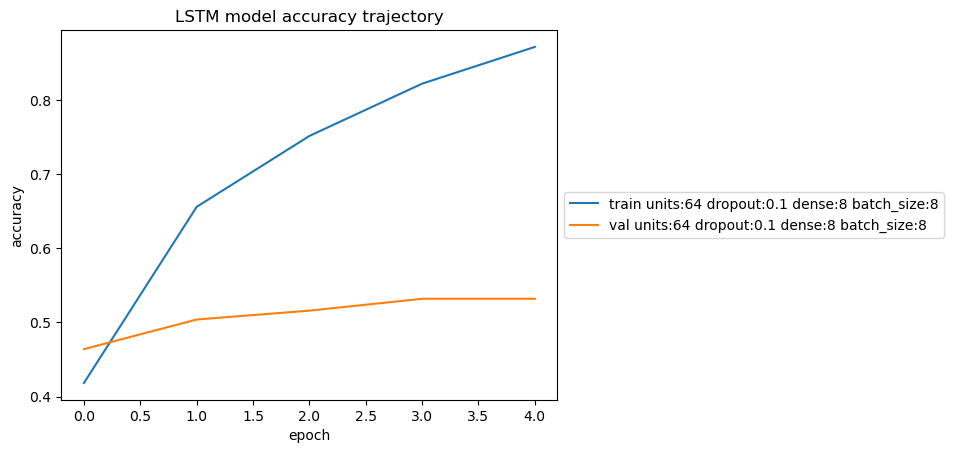

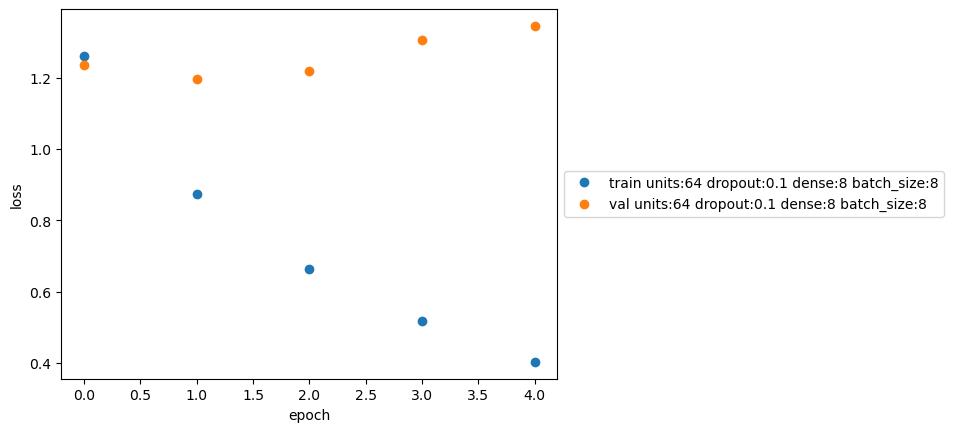

In [39]:
import matplotlib.pyplot as plt
key = "units:"+str(64)+" dropout:"+str(0.1)+ " dense:"+str(8)+" batch_size:"+str(8)
plt.plot(results[key].history['accuracy'], label="train "+key)
plt.plot(results[key].history['val_accuracy'], label="val "+key)
plt.title('LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plotting loss trajectory
plt.plot(results[key].history['loss'],'o', label="train "+key)
plt.plot(results[key].history['val_loss'],'o', label="val "+key)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


# plt.plot(lstm_model_results2.history['accuracy'], label="train ")
# plt.plot(lstm_model_results2.history['val_accuracy'], label="val ")
# plt.title('LSTM model accuracy trajectory')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()

# # Plotting loss trajectory
# plt.plot(lstm_model_results2.history['loss'],'o', label="train ")
# plt.plot(lstm_model_results2.history['val_loss'],'o', label="val ")
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()

In [ ]:
with open('./lstm_best', 'wb') as fp:
    pickle.dump(results, fp)

8/8 [==============================] - 0s 49ms/step


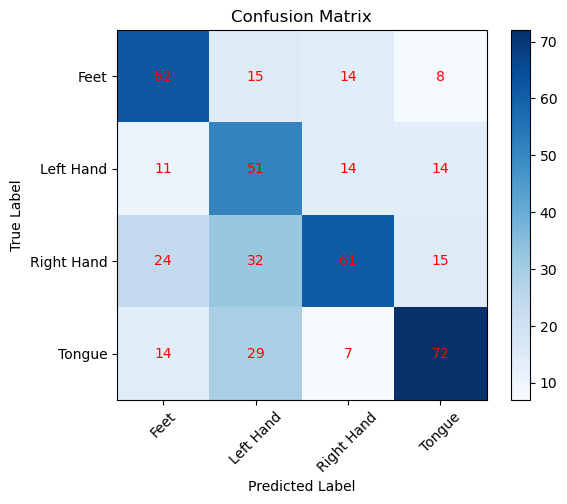

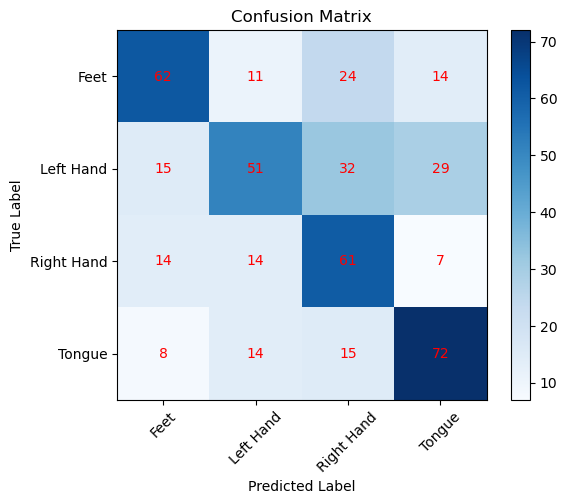

              precision    recall  f1-score   support

           0       0.63      0.56      0.59       111
           1       0.57      0.40      0.47       127
           2       0.46      0.64      0.54        96
           3       0.59      0.66      0.62       109

    accuracy                           0.56       443
   macro avg       0.56      0.56      0.55       443
weighted avg       0.56      0.56      0.55       443



In [43]:
from utils import confusion_matrix

model = keras.models.load_model('../Models/0_LSTM_0.555304765701294_64_0.1_8_8.h5')
y_test_pred = model.predict(x_test)
y_val_pred = model.predict(x_valid)

y_valid_categorical = np.argmax(y_valid, axis=1)
y_val_pred_categorical = np.argmax(y_val_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
# y_test_categorical = np.argmax(y_test, axis=1)

# List of class names (adjust as per your dataset)
class_names = ['Feet', 'Left Hand', 'Right Hand', 'Tongue']

# Plot confusion matrix
true_labels = np.argmax(y_test, axis=1)

## Testing 

confusion_matrix.plot_confusion_matrix(y_test_pred_classes, true_labels, class_names, True, '../Gallery/LSTM_confusion_matrix.png')
confusion_matrix.metrics_report(true_labels, y_test_pred_classes)
